## qBraid Runtime: Bloqade batch submission to QuEra Aquila

In [ ]:
%%capture

%pip install 'qbraid[bloqade,braket,visualization]>=0.9.8'

In [1]:
import numpy as np
from bloqade.analog import var
from bloqade.analog.atom_arrangement import Square

from qbraid.runtime import QbraidProvider
from qbraid.visualization import plot_histogram, plot_runtime_conversion_scheme

Create adiabatic program batch using Bloqade

In [2]:
adiabatic_durations = [0.4, 3.2, 0.4]

max_detuning = var("max_detuning")
adiabatic_program = (
    Square(3, lattice_spacing="lattice_spacing")
    .rydberg.rabi.amplitude.uniform.piecewise_linear(
        durations=adiabatic_durations, values=[0.0, "max_rabi", "max_rabi", 0.0]
    )
    .detuning.uniform.piecewise_linear(
        durations=adiabatic_durations,
        values=[
            -max_detuning,  # scalar variables support direct arithmetic operations
            -max_detuning,
            max_detuning,
            max_detuning,
        ],
    )
    .assign(max_rabi=15.8, max_detuning=16.33)
    .batch_assign(lattice_spacing=np.arange(4.0, 7.0, 1.0))
)

Target QuEra Aquila device using QbraidProvider

In [3]:
provider = QbraidProvider()

In [4]:
device = provider.get_device("quera_aquila")

print(device.status())
print(device.profile.experiment_type)
print(device.profile.program_spec)

DeviceStatus.ONLINE
ExperimentType.AHS
ProgramSpec(AnalogHamiltonianSimulation, braket_ahs)


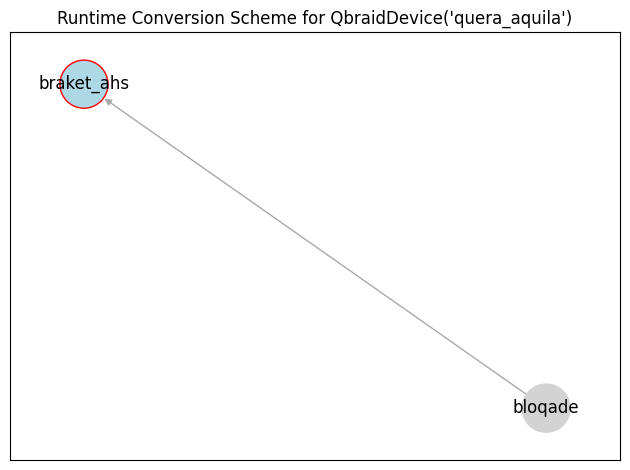

In [5]:
plot_runtime_conversion_scheme(device)

Submit quantum task(s)

In [6]:
job_batch = device.run(adiabatic_program, shots=10, tags={"batch": "adiabatic-test-1"})

In [10]:
print(f"{'Job Id':<60} {'Status':<15} {'Queue Position':<5}")
print("-" * 50)
for job in job_batch:
    print(f"{job.id:<60} {job.status():<15} {job.queue_position():<5}")

Job Id                                                       Status          Queue Position
--------------------------------------------------
quera_aquila-ryanjh88-qjob-y1n81sb5lfumwor8lcrd              JobStatus.QUEUED 3    
quera_aquila-ryanjh88-qjob-dzabkp8u8zg29lis4rgo              JobStatus.QUEUED 1    
quera_aquila-ryanjh88-qjob-8byjzumhhirj4e54qoaa              JobStatus.QUEUED 2    


In [11]:
results = [job.result() for job in job_batch]

shot_results_batch = [result.data.measurements for result in results]

counts_batch = [result.data.get_counts() for result in results]

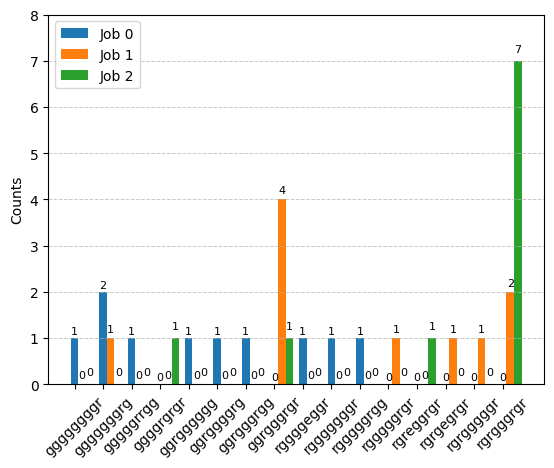

In [12]:
plot_histogram(counts_batch)